In [1]:
import numpy as np
import pandas as pd
import math
import random
import bisect 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from ngboost import NGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.isotonic import IsotonicRegression

# Hide some warnings
pd.options.mode.chained_assignment = None 

In [2]:
# Load four sheets from excel file

denver = pd.read_excel('Datas.xls', sheet_name='DEN')
newyork = pd.read_excel('Datas.xls', sheet_name='NYC')
sanfrancisco = pd.read_excel('Datas.xls', sheet_name='SFC')
texas = pd.read_excel('Datas.xls', sheet_name='TXS')

# Set random seed
random.seed(48)

In [3]:
# Cleen data to make it easier to handle

denver['station'] = denver['station'].replace(np.nan,'DENVER INTL AP')
denver['station'] = denver['station'].replace('DENVER INTL AP', 'DEN')
newyork['station'] = newyork['station'].replace(np.nan, 'JFK')
sfc = sanfrancisco.drop(columns = 'valid', axis=1)

In [4]:
#Function to rename columns 

def rename_columns(df, col_names):
    cols = df.columns
    for col, new_col in zip(cols, col_names):
        df.rename(columns={col:new_col}, inplace=True)

In [5]:
# Rename columns in all datasets to same column names

col_names = ['station', 'skycloud', 'day', 'tmpf', 'feel', 
             'zenith', 'azimuth', 'glob', 'direct', 
             'diffused', 'albedo', 'time', 'power']

rename_columns(denver, col_names)
rename_columns(newyork, col_names)
rename_columns(sfc, col_names)
rename_columns(texas, col_names)

In [6]:
# Join all 4 datasets into a single dataframe

frames = [denver, newyork, sfc, texas]
data = pd.concat(frames)


# Create dataset for denver station
den = data.loc[data['station'] == 'DEN']

In [7]:
# Drop columns with low correlation

den = den.drop(columns = ['skycloud', 'feel', 'albedo'], axis=1)

In [8]:
# Drop rows with azimuth = -99 values

den.drop(den.index[den['azimuth'] == -99], inplace = True)

In [9]:
# Create X and y values

X_val = den.drop(columns = ['station', 'power','day'], axis=1) 
X = X_val.values
y = den.power.values

In [10]:
# Train test split and scale data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=300, random_state=48, shuffle=True)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

scaler = MinMaxScaler()
X_tr_sc = scaler.fit_transform(X_train)
X_te_sc = scaler.transform(X_test)
y_tr_sc = scaler.fit_transform(y_train)
y_te_sc = scaler.transform(y_test)

In [11]:
X_calib, X_true_test, y_calib, y_true_test = train_test_split(X_te_sc, y_te_sc, test_size=0.5, random_state=48, shuffle=True)

In [12]:
# Create length scale and length scale bounds

feature_len = len(X_tr_sc[0])
len_scale = np.ones(feature_len)

hp_low = 1e-10
hp_high = 100000

hp_bounds = np.zeros(shape = (feature_len,2))
hp_bounds[:,0] = hp_low
hp_bounds[:,1] = hp_high

In [13]:
# sklearn gpr model matern 52 kernel + white kernel
def gpr_model(len_sc, hp_b, X_tr, y_tr, X_cal, X_test):
    kernel = Matern(length_scale=len_sc, length_scale_bounds=hp_b, nu=2.5) + WhiteKernel(noise_level=0.1)
    model = GaussianProcessRegressor(kernel=kernel)
    model.fit(X_tr, y_tr)
    mean_calib, std_calib = model.predict(X_cal, return_std=True)
    mean_true_test, std_true_test = model.predict(X_test, return_std=True)
    
    return mean_calib, std_calib, mean_true_test, std_true_test

In [14]:
gpr_mean_calib, gpr_std_calib, gpr_mean_true_test, gpr_std_true_test = gpr_model(len_scale, hp_bounds, X_tr_sc, y_tr_sc, X_calib, X_true_test)

In [15]:
def ngb_model(X_tr, y_tr, X_cal, X_test):
    ngb = NGBRegressor()
    ngb.fit(X_tr, y_tr)
    ngb_preds_calib = ngb.pred_dist(X_cal)
    ngb_preds_test = ngb.pred_dist(X_test)
    
    mean_calib = ngb_preds_calib.params['loc']
    std_calib = ngb_preds_calib.params['scale']
    mean_test = ngb_preds_test.params['loc']
    std_test = ngb_preds_test.params['scale']
    
    return mean_calib, std_calib, mean_test, std_test

In [16]:
ngb_mean_calib, ngb_std_calib, ngb_mean_true_test, ngb_std_true_test = ngb_model(X_tr_sc, y_tr_sc, X_calib, X_true_test)

C:\Users\hartm\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[iter 0] loss=0.2639 val_loss=0.0000 scale=1.0000 norm=0.4704
[iter 100] loss=-0.4870 val_loss=0.0000 scale=2.0000 norm=0.8366
[iter 200] loss=-1.0777 val_loss=0.0000 scale=2.0000 norm=0.8157
[iter 300] loss=-1.4716 val_loss=0.0000 scale=2.0000 norm=0.7935
[iter 400] loss=-1.7144 val_loss=0.0000 scale=2.0000 norm=0.7963


### CRUDE Calibration

In [17]:
def find_z_scores(y_calib, mean_calib, std_calib):
    z_calib = []

    for i in range(len(mean_calib)):
        dif = y_calib[i] - mean_calib[i] 
        z_st = dif/std_calib[i]
        bisect.insort(z_calib, z_st) #sorted list of z_star values

    # This is noted as Zc in the article
    z_c = np.concatenate(z_calib, axis=0 )  
    
    return z_c

In [18]:
# function to find quantiles, p is the target quantile level

def CRUDE(z_c, mean_calib):
    p_values = np.arange(0.05,1,0.05)
    
    # empty 2d array for z_p scores for all p values
    z_p = np.zeros((len(p_values), 2))
    
    for p in range(len(p_values)):
        
        #define higher and lower boundries
        p_up = round(p_values[p]+(1-p_values[p])/2, 3)
        p_low = round(1-p_up, 3)

        #determine which Zc values to include in both boundries
        z_p_up = z_c[int(p_up * len(mean_calib))]
        z_p_low = z_c[int(p_low * len(mean_calib))]
        
        z_p[p,0] = z_p_low
        z_p[p,1] = z_p_up
        
    return z_p

In [19]:
def find_quantiles(z_p, mean_true_test, std_true_test):
 
    # empty 2*z_p array for lower and higher boundry values
    q = np.zeros((len(mean_true_test), 2*len(z_p)))
    index = 0
    
    for j in range(len(z_p)):  
        for i in range(len(mean_true_test)):
            #Define the lower and higher boundry for each data point
            q_low = mean_true_test[i] + std_true_test[i] * z_p[j,0]
            q_up = mean_true_test[i] + std_true_test[i] * z_p[j,1]
            
            q[i,index] = q_low
            q[i,index + 1] = q_up
        
        index = index + 2       
    return q

In [20]:
def crude_coverage(q, y_true_test):

    p_values = np.arange(0.05,1,0.05)
    cov = []
    index = 0

    for p in p_values:
        count = 0
        for i in range(len(q)):
            if (y_true_test[i] > q[i,index]) and (y_true_test[i] < q[i,index+1]):
                count = count + 1 
        index = index + 2
        cov.append(count/len(q))
        
    return cov

In [21]:
z_c_gpr = find_z_scores(y_calib, gpr_mean_calib, gpr_std_calib)
z_p_gpr = CRUDE(z_c_gpr, gpr_mean_calib)
q_gpr = find_quantiles(z_p_gpr, gpr_mean_true_test, gpr_std_true_test)
q_gpr_calib = find_quantiles(z_p_gpr, gpr_mean_calib, gpr_std_calib)
cov_crude_gpr = crude_coverage(q_gpr, y_true_test)

In [22]:
z_c_ngb = find_z_scores(y_calib, ngb_mean_calib, ngb_std_calib)
z_p_ngb = CRUDE(z_c_ngb, ngb_mean_calib)
q_ngb = find_quantiles(z_p_ngb, ngb_mean_true_test, ngb_std_true_test)
q_ngb_calib = find_quantiles(z_p_ngb, ngb_mean_calib, ngb_std_calib)
cov_crude_ngb = crude_coverage(q_ngb, y_true_test)

### Kuleshov calibration

In [23]:
def find_conf_interval(mean_calib, y_calib, std_calib):

    cdfs = []

    for i in range(len(mean_calib)):
        dif = y_calib[i] - mean_calib[i] 
        z_st = dif/std_calib[i]
        cdf = stats.norm.cdf(z_st)
        cdfs.append(cdf)

#         if cdf < 0.5:
#             centered.append(1 - 2*cdf)
#         else:
#             centered.append(cdf - (1-cdf))

    # This is the Ft from the article
    CI_cent = np.concatenate(cdfs, axis=0 )   
    
    return CI_cent

In [24]:
def find_coverage(CI_cent):
    
    cover_cent = []

    for i in range(len(CI_cent)):
        count = 0
        for j in range(len(CI_cent)):
            if CI_cent[j] < CI_cent[i]:
                count = count +1
        cov_cent = count/len(CI_cent)
        cover_cent.append(cov_cent)
    
    return cover_cent

In [28]:
# tol = 0.001
# delta_mid = 2*tol
# q_lower = 0
# q_upper = 6 * (max(ngb_mean_true_test) - min(ngb_mean_true_test))
# q_mid = 0.5 * (q_lower + q_upper)

# print(max(y_true_test),min(y_true_test))

# print(max(ngb_mean_true_test),min(ngb_mean_true_test))

# print(delta_mid, q_lower, q_upper, q_mid)

# e_low = stats.norm.cdf(ngb_mean_true_test[0]-q_mid)
# e_upp = stats.norm.cdf(ngb_mean_true_test[0]+q_mid)

# e_low1 = stats.norm.cdf(ngb_mean_true_test[1]-q_mid)
# e_upp1 = stats.norm.cdf(ngb_mean_true_test[1]+q_mid)

# print(e_low, e_upp)
# print(e_low1, e_upp1)

In [721]:
def train_ir_calc_coverage(CI_cent, cover_cent, mean_true_test, y_values, std_true_test):

    ir = IsotonicRegression()
    # empirical (H) first and predicted (P) next
    h = ir.fit_transform(CI_cent, cover_cent)

    coverage_cal_cent = []
    coverage_uncal_cent = []

    p_values = np.arange(0.05,1,0.05)
    cdf_cals = np.zeros((len(mean_true_test), 1))
    cdf_uncals = np.zeros((len(mean_true_test), 1))
    limits = np.zeros((len(mean_true_test), len(p_values)))
    
    q_upper_init = 2.5*(max(mean_true_test) - min(mean_true_test))
    
    for p in reversed(range(len(p_values))):
        count_cal = 0
        count_cal_centered = 0
        count_uncal = 0
        
        #get upper and lower p values
        p_up = round(p_values[p]+(1-p_values[p])/2, 3)
        p_low = round(1-p_up, 3)
        
        for j in range(len(mean_true_test)):
            dif = y_values[j] - mean_true_test[j]
            z_st = dif/std_true_test[j]   
            cdf_uncal = stats.norm.cdf(z_st)
            
            tol = 0.001
            delta_mid = 2*tol
            q_lower = 0
            q_upper = q_upper_init
            if p < len(p_values) - 1:
                q_upper = limits[j, p+1]
            q_mid = 0.5 * (q_lower + q_upper)
            
            #recalibrate the cdfs using the trained isotonic regression model
            cdf_cal = ir.predict(cdf_uncal)

            while abs(delta_mid) > tol: 
                q_mid = 0.5 * (q_lower + q_upper)
                
                e_low = stats.norm.cdf(-q_mid/std_true_test[j])
                e_upp = stats.norm.cdf(q_mid/std_true_test[j])
                
                e_low = e_low.reshape((1, 1))
                e_upp = e_upp.reshape((1, 1))
                
                s_low = ir.predict(e_low)
                if np.isnan(s_low):
                    s_low = 0
                    
                s_upp = ir.predict(e_upp)
                if np.isnan(s_upp):
                    s_upp = 1
                
                true_ci = s_upp - s_low
                delta_mid = true_ci - p_values[p]

                if delta_mid > 0:
                    q_upper = q_mid
                else:
                    q_lower = q_mid
                                 
                    
            limits[j, p] = q_mid
            
            #Get cdfs, both calculated and uncalculated
            cdf_cals[j,0] = cdf_cal
            cdf_uncals[j,0] = cdf_uncal

            #calculate coverage
            if cdf_cal <= p_values[p]:
                count_cal = count_cal+1
                
            if y_values[j] < mean_true_test[j] + limits[j,p] and y_values[j] > mean_true_test[j] - limits[j,p]:
                count_cal_centered = count_cal_centered+1 

            if cdf_uncal <= p_values[p]:
                count_uncal = count_uncal+1

#         print('Computed p limits',p)
#         print('coverage_cal_cent',count_cal/len(mean_true_test))
#         print('coverage_cal_centered',count_cal_centered/len(mean_true_test))
#         print('coverage_uncal_cent',count_uncal/len(mean_true_test))
        coverage_cal_cent.append(count_cal/len(mean_true_test))
        coverage_uncal_cent.append(count_uncal/len(mean_true_test))
        
    return coverage_cal_cent, coverage_uncal_cent, cdf_cals, cdf_uncals, limits

#### Kuleshov recalibration NgBoost

In [722]:
# Get conf intervals+coverage and get recalibrated values for the test set
conf_int_ngb = find_conf_interval(ngb_mean_calib, y_calib, ngb_std_calib)
coverage_ngb = find_coverage(conf_int_ngb)
cov_kuleshov_calc_ngb, cov_uncal_ngb, cdf_cals_ngb, cdf_uncals_ngb, limits_ngb = train_ir_calc_coverage(conf_int_ngb, coverage_ngb, 
                                                                            ngb_mean_true_test, y_true_test, ngb_std_true_test)

In [726]:
# Get recalibrated values for the calibration set
cov_kuleshov_calc_ngb_calib, cov_uncal_ngb_calib, cdf_cals_ngb_calib, cdf_uncals_ngb_calib, limits_ngb_calib = train_ir_calc_coverage(
    conf_int_ngb, coverage_ngb, ngb_mean_calib, y_calib, ngb_std_calib)

#### Kuleshov recalibration GPR

In [727]:
# Get conf intervals+coverage and get recalibrated values for the test set
conf_int_gpr = find_conf_interval(gpr_mean_calib, y_calib, gpr_std_calib)
coverage_gpr = find_coverage(conf_int_gpr)
cov_kuleshov_calc_gpr, cov_uncal_gpr, cdf_cals_gpr, cdf_uncals_gpr, limits_gpr = train_ir_calc_coverage(conf_int_gpr, coverage_gpr, 
                                                                            gpr_mean_true_test, y_true_test, gpr_std_true_test)

In [728]:
# Get recalibrated values for the calibration set
cov_kuleshov_calc_gpr_calib, cov_uncal_gpr_calib, cdf_cals_gpr_calib, cdf_uncals_gpr_calib, limits_gpr_calib = train_ir_calc_coverage(
    conf_int_gpr, coverage_gpr, gpr_mean_calib, y_calib, gpr_std_calib)

In [729]:
# print(limits_gpr_calib)
# print(limits_ngb_calib)

In [730]:
# print(q_gpr_calib)
# print(q_ngb_calib)

In [731]:
# X_len = 20
# x = np.arange(X_len) 
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,5))

# ax1.plot(x[:X_len], ngb_mean_true_test[0:X_len], label='predicted')
# #ax1.plot(x[:X_len])
# ax1.fill_between(x[:X_len], ngb_mean_true_test[0:20] - limits_ngb[0:20,5], ngb_mean_true_test[0:20] + limits_ngb[0:20,5],
#                  color='gray', alpha=0.2)
# ax1.fill_between(x[:X_len], ngb_mean_true_test[0:20] - limits_ngb[0:20,18], ngb_mean_true_test[0:20] + limits_ngb[0:20,18],
#                  color='salmon', alpha=0.2)

# ax2.plot(x[:X_len], ngb_mean_true_test[0:X_len], label='predicted')
# ax2.fill_between(x[:X_len], ngb_mean_true_test[0:20] - cdf_cals_ngb[0:20, 0]/2, ngb_mean_true_test[0:20] + cdf_cals_ngb[0:20, 0]/2,
#                  color='gray', alpha=0.2)

# ax3.plot(x[:X_len], ngb_mean_true_test[0:20], label='predicted')
# ax3.fill_between(x[:X_len], q_ngb[0:20,36], q_ngb[0:20,37],
#                  color='gray', label='kuleshov calibrated intervals', alpha=0.2)
# plt.show()

### Create data sets of ranges

In [512]:
def ranges(q, mean, limits):
    kuleshov_range = np.zeros((len(q), len(q[0])))

    index = 0
    for p in range(len(limits[0])):
        for i in range(len(q)):
            kuleshov_range[i,index] = mean[i] - limits[i,p]
            kuleshov_range[i,index+1] = mean[i] + limits[i,p]
        index = index + 2
    
    return q, kuleshov_range

In [513]:
ngb_crude_range, ngb_kuleshov_range = ranges(q_ngb_calib, ngb_mean_calib, limits_ngb_calib)
gpr_crude_range, gpr_kuleshov_range = ranges(q_gpr_calib, gpr_mean_calib, limits_gpr_calib)

Each slot in the data set contains the conf intervals for that point from 0.05 up to 0.95. Hence, each slot has 38 values in it, the even values are the lower boundry of the interval while the odd values are the higher boundry. 

### Weights for intervals

In [738]:
def get_weighted_ranges(crude_range, kuleshov_range, conf_limit):

    # Set two weights, lower and upper, each ranging from 0 to 1 changing 0.1 at a time
    w_lower = np.arange(0.0,1.1,0.1)
    w_upper = np.arange(0.0,1.1,0.1)

    # Save the final values in one array for upper + lower boundries, and one for the interval
    w_ranges = np.zeros((len(crude_range), 2*len(w_upper)*len(w_lower)))
    w_interval = np.zeros((len(crude_range), len(w_upper)*len(w_lower)))

    index1 = 0
    index2 = 0
    
    # Iterate through each combination of w_upper and w_lower
    for w1 in w_lower:
        for w2 in w_upper: 
            # Iterate through all values in the calibrated ranges data sets
            for i in range(len(crude_range)):
                # Calculate an upper and lower boundry based on previous ranges and weights
                lb = w1 * kuleshov_range[i,conf_limit] + (1-w1) * crude_range[i,conf_limit]
                ub = w2 * kuleshov_range[i,conf_limit +1] + (1-w2) * crude_range[i,conf_limit +1]

#                 if i == 0:
#                     print(w1, w2, kuleshov_range[i,conf_limit], kuleshov_range[i,conf_limit+1], 
#                           crude_range[i,conf_limit], crude_range[i,conf_limit +1])
#                     print(lb, ub)
                # Save resulting interval and lower + upper boundry for each point
                w_interval[i, index1] = ub - lb
                w_ranges[i, index2] = lb
                w_ranges[i, index2+1] = ub

            index1 = index1 + 1
            index2 = index2 + 2
    
    # Returns an array 2249 values long and each point contains 121 intervals/ 242 ranges
    return w_interval, w_ranges

In [740]:
c_lim = np.arange(0,len(ngb_crude_range[0]),2)
weight_intervals_ngb = []
weight_ranges_ngb = []

# Iterate through all confidence limits (0.05 to 0.95)
for i in c_lim:
    w_interval_ngb, w_ranges_ngb = get_weighted_ranges(ngb_crude_range, ngb_kuleshov_range, i)
    
    # Save results in a list of intervals/ranges
    weight_intervals_ngb.append(w_interval_ngb)
    weight_ranges_ngb.append(w_ranges_ngb)


In [741]:
def get_coverage_weighted(w_interval, w_ranges, y_calib, mean_calib):

    index = 0
    counter = []
    
    # Iterate through each weight combination
    for w in range(len(w_interval[0])):
        count = 0
        # Iterate through each point (2249 points)
        for i in range(len(w_ranges)):

            # Check if the prediction is in the interval
            if y_calib[i] > w_ranges[i, index] and y_calib[i] < w_ranges[i, index + 1]:
                count = count + 1
                
#             if i == 1000:
#                 print(i, w, w_ranges[i, index], w_ranges[i, index+1], y_calib[i], mean_calib[i], count)
                
        # Divide by number of points to get coverage, save in counter for each weight combination
        counter.append(float(count)/float(len(w_ranges)))
        index = index + 2
    
    # Returns a list of all weight combination's coverage
    return counter

In [742]:
coverages = []

# Iterate through each confidence limit (0.05 to 0.95)
for (ran, inter) in zip(weight_ranges_ngb, weight_intervals_ngb):

    # Get the coverage of each weight combination
    counter_ngb = get_coverage_weighted(inter, ran, y_calib, ngb_mean_calib)
    coverages.append(counter_ngb)
    
# Coverages is a 19*121 sized array for all coverages of all weights

In [744]:
MSE = np.zeros(len(coverages[0]))
p_val = np.arange(0.05,1,0.05)

for w in range(len(coverages[0])):
    for (p,c) in  zip(p_val,range(len(coverages))):
        cov = coverages[c]
        dif = cov[w] - p
                
        MSE[w] = MSE[w] + dif*dif
        #print(w, round(p, 3), c, dif, cov[w], MSE[w])
#print(MSE)

In [745]:
def calc_sharpness_weighted(w_interval):

    index = 0
    sharpness = []
    
    # Iterate through each weight combination
    for w in range(len(w_interval[0])):
        sum_ranges = 0
        count_invalid = 0
        
        # Iterate through each point (2249 points)
        for i in range(len(w_interval)):   
            sum_ranges = sum_ranges + w_interval[i,w] 

        #print(sum_ranges, sum_ranges/len(w_interval))
        sharpness.append(sum_ranges/len(w_interval))
    
    # Returns a list of all weight combination's sharpness
    return sharpness

In [750]:
sharpness = []
for i in range(len(weight_intervals_ngb)):
    sharpness.append(calc_sharpness_weighted(weight_intervals_ngb[i]))
    
sharpness = np.array(sharpness)

In [747]:
# sharpness = np.array(sharpness)
# print(sharpness[0,10], sharpness[1,10], sharpness[2,10], sharpness[3,10], sharpness[4,10], sharpness[5,10])
# print(sharpness[6,10], sharpness[7,10], sharpness[8,10], sharpness[9,10], sharpness[10,10], sharpness[11,10])
# print(sharpness[0,0], sharpness[1,0], sharpness[2,0], sharpness[3,0], sharpness[4,0], sharpness[5,0])
# print(sharpness[6,0], sharpness[7,0], sharpness[8,0], sharpness[9,0], sharpness[10,0], sharpness[11,0])
# #print(sharpness[1,:])

# print(sharpness[18,10])
# print(sharpness[18,0])

In [748]:
# sharpness[0]

In [751]:
sharp_score = []
for w in range(len(sharpness[0])):
    sum_sharp = 0
    for p in range(len(sharpness)-1):
        sum_sharp = sum_sharp + sharpness[p,w]
        
    #print((sharpness[0,w] + sharpness[1,w] + sharpness[2,w] + sharpness[3,w])/4)
    sharp_score.append(sum_sharp/(len(sharpness)-1))


In [752]:
# print(sharp_score)

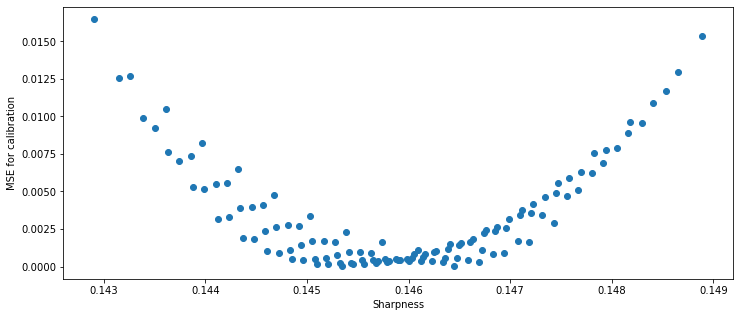

In [753]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.plot(sharp_score, MSE, 'o')
plt.xlabel('Sharpness')
plt.ylabel('MSE for calibration')

plt.show()

In [754]:
sharp_score2 = np.array(sharp_score)
sharp_score3 = sharp_score2.reshape(-1,1)

cal_score2 = np.array(MSE)
cal_score3 = cal_score2.reshape(-1,1)

scaler = MinMaxScaler()
sharp_sc = scaler.fit_transform(sharp_score3)
cal_sc = scaler.fit_transform(cal_score3)

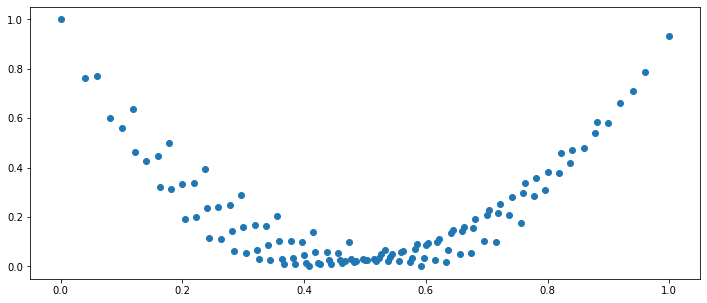

In [755]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.plot(sharp_sc, cal_sc, 'o')
plt.show()

In [702]:
#min_ = sharp_sc[0] + cal_sc[0]
res = []

for i in range(len(sharp_sc)):
    #print(sharp_score[i], MSE[i], sharp_score[i]-MSE[i])
    if sharp_sc[i] < 0.25 and cal_sc[i] < 0.25:
        res.append(i)

In [703]:
print(res)

[41, 53, 65, 76]


In [715]:
# for i in range(len(sharp_sc)):
#     print(sharp_sc[i], cal_sc[i])

In [713]:
#min_ = sharp_sc[0] + cal_sc[0]
res2 = []

for i in range(len(sharp_sc)):
    #print(sharp_score[i], MSE[i], sharp_score[i]-MSE[i])
    if sharp_sc[i] + cal_sc[i] < 0.35:
        res2.append(i)

In [714]:
print(res2)

[87]


In [716]:
print(sharp_sc[87], cal_sc[87])
print(sharp_sc[41], cal_sc[41])
print(sharp_sc[53], cal_sc[53])
print(sharp_sc[65], cal_sc[65])
print(sharp_sc[76], cal_sc[76])

[0.2852681] [0.06394839]
[0.24075259] [0.2356924]
[0.22225776] [0.20157378]
[0.20376293] [0.19058014]
[0.24451551] [0.11653672]


In [756]:
# sharpness = []
# for i in range(len(weight_intervals_ngb)):
#     sharpness.append(calc_sharpness_weights(weight_intervals_ngb[i]))

In [757]:
# p_val = np.arange(0.05,1,0.05)
# best_w_cov = []

# #Iterate through each sharpness for each conf interval
# for (p,s) in zip(p_val,range(len(sharpness))):
#     sharp = sharpness[s]
    
#     # Set the first sharpness score as min_
#     min_ = sharp[0]
    
#     #Iterate through all 121 weight combinations 
#     for i in range(len(coverages[0])):
#         # Find which weight combo has the best coverage
#         if sharp[i] <= min_:
#             min_ = sharp[i]
#             res = i
#     best_w_cov.append(res)

### Combine intervals

In [368]:
def comb_intervals1(crude_range, kuleshov_range):
    comb_intervals = np.zeros((len(crude_range), 2))

    for i in range(len(crude_range)):
        crude_dif = (crude_range[i,1] - crude_range[i,0])
        kuleshov_dif = (kuleshov_range[i,1]- kuleshov_range[i,0])
        
        if crude_dif < kuleshov_dif or np.isnan(kuleshov_dif):
            comb_intervals[i,0] = crude_range[i,0]
            comb_intervals[i,1] = crude_range[i,1]
        else:
            comb_intervals[i,0] = kuleshov_range[i,0]
            comb_intervals[i,1] = kuleshov_range[i,1]
        
    return comb_intervals

In [369]:
def comb_intervals2(crude_range, kuleshov_range):
    comb_intervals = np.zeros((len(crude_range), 2))

    for i in range(len(crude_range)):
        comb_intervals[i,1] = min(crude_range[i,1], kuleshov_range[i,1])
        comb_intervals[i,0] = max(crude_range[i,0], kuleshov_range[i,0])
        
    return comb_intervals

In [370]:
ngb_comb_intervals = comb_intervals1(ngb_crude_range, ngb_kuleshov_range)
gpr_comb_intervals = comb_intervals1(gpr_crude_range, gpr_kuleshov_range)

ngb_comb_intervals2 = comb_intervals2(ngb_crude_range, ngb_kuleshov_range)
gpr_comb_intervals2 = comb_intervals2(gpr_crude_range, gpr_kuleshov_range)

In [121]:
# X_len = 50
# x = np.arange(X_len)  

# fig, ax = plt.subplots(1,1, figsize=(15, 6))
# plt.plot(x[:X_len], y_true_test[0:50], label='real')
# plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
# plt.fill_between(x[:X_len], ngb_mean_true_test[0:50] - cdf_uncals_ngb[0:50,0]/2, ngb_mean_true_test[0:50] + cdf_uncals_ngb[0:50,0]/2,
#                  color='gray', label='uncalibrated intervals', alpha=0.2)
# plt.ylim(-0.55, 1.5)

# plt.legend()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(15, 6))
# plt.plot(x[:X_len], y_true_test[0:50], label='real')
# plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
# plt.fill_between(x[:X_len], ngb_mean_true_test[0:50] - cdf_cals_ngb[0:50,0]/2, ngb_mean_true_test[0:50] + cdf_cals_ngb[0:50,0]/2,
#                  color='gray', label='kuleshov calibrated intervals', alpha=0.2)
# plt.ylim(-0.55, 1.5)

# plt.legend()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(15, 6))
# plt.plot(x[:X_len], y_true_test[0:50], label='real')
# plt.plot(x[:X_len], ngb_mean_true_test[0:X_len], '--', label='predicted')
# plt.fill_between(x[:X_len], ppf_ngb[0:X_len,0], ppf_ngb[0:X_len,37],
#                  color='gray', alpha=0.2, label='kuleshov ppf 0.95')
# plt.fill_between(x[:X_len], ppf_ngb[0:X_len,10], ppf_ngb[0:X_len,27],
#                  color='salmon', alpha=0.2)
# plt.ylim(-0.55, 1.5)

# plt.legend()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(15, 6))
# plt.plot(x[:X_len], y_true_test[0:50], label='real')
# plt.plot(x[:X_len], gpr_mean_true_test[0:50], '--', label='predicted')
# plt.fill_between(x[:X_len], q_gpr[0:50,36], q_gpr[0:50,37],
#                  color='gray', label='CRUDE calibrated intervals', alpha=0.2)
# plt.ylim(-0.55, 1.5)

# plt.legend()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(15, 6))
# plt.plot(x[:X_len], y_true_test[0:50], label='real')
# plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
# plt.fill_between(x[:X_len], ngb_comb_intervals[0:50,0], ngb_comb_intervals[0:50,1],
#                  color='gray', label='combined calibrated intervals', alpha=0.2)
# plt.ylim(-0.55, 1.5)

# plt.legend()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(15, 6))
# plt.plot(x[:X_len], y_true_test[0:50], label='real')
# plt.plot(x[:X_len], ngb_mean_true_test[0:50], '--', label='predicted')
# plt.fill_between(x[:X_len], ngb_comb_intervals2[0:50,0], ngb_comb_intervals2[0:50,1],
#                  color='gray', label='combined calibrated intervals', alpha=0.2)
# plt.ylim(-0.55, 1.5)

# plt.legend()
# plt.show()

### Calculating sharpness

In [371]:
def get_CI(interval):
    CI = np.zeros((len(interval), 1))
    for i in range(len(interval)):
        CI[i] = interval[i,1] - interval[i,0]
    return CI

In [372]:
ngb_CI_crude = get_CI(ngb_crude_range)
gpr_CI_crude = get_CI(gpr_crude_range)

ngb_CI_kule = get_CI(ngb_kuleshov_range)
gpr_CI_kule = get_CI(gpr_kuleshov_range)

ngb_CI_comb = get_CI(ngb_comb_intervals)
gpr_CI_comb = get_CI(gpr_comb_intervals)

ngb_CI_comb2 = get_CI(ngb_comb_intervals2)
gpr_CI_comb2 = get_CI(gpr_comb_intervals2)

In [373]:
def calc_sharpness(cdf_cals):

    var_ngb = 0
    count_nan = 0
    for i in range(len(cdf_cals)):
        if math.isnan(cdf_cals[i]):
            count_nan = count_nan + 1
        else:
            var_ngb = var_ngb + cdf_cals[i]


    sharpness = var_ngb/(len(cdf_cals-count_nan))
    return sharpness

In [374]:
conf_int = [ngb_CI_kule, gpr_CI_kule, ngb_CI_crude, gpr_CI_crude, 
          ngb_CI_comb, gpr_CI_comb, ngb_CI_comb2, gpr_CI_comb2]
names = ['Kuleshov NgBoost', 'Kuleshov GPR', 'CRUDE NgBoost', 'CRUDE GPR',
        'Comb 1 NgBoost', 'Comb 1 GPR', 'Comb 2 NgBoost', 'Comb 2 GPR']

sharp_ngb = np.zeros((int(len(names)/2), 1))
sharp_gpr = np.zeros((int(len(names)/2), 1))
for conf, i in zip(conf_int, range(len(names))):
    if i%2 < 1:
        sharpness = calc_sharpness(conf)
        sharp_ngb[int(i/2)] = sharpness
    else:
        sharpness = calc_sharpness(conf)
        sharp_gpr[int(i/2)] = sharpness
        
    print(names[i], sharpness)


Kuleshov NgBoost [0.01079064]
Kuleshov GPR [0.00537065]
CRUDE NgBoost [0.01224615]
CRUDE GPR [0.00848726]
Comb 1 NgBoost [0.01079064]
Comb 1 GPR [0.00537065]
Comb 2 NgBoost [0.00458634]
Comb 2 GPR [-0.0079031]


In [375]:
sharp_ngb = np.concatenate(sharp_ngb, axis=0 )
sharp_gpr = np.concatenate(sharp_gpr, axis=0 )

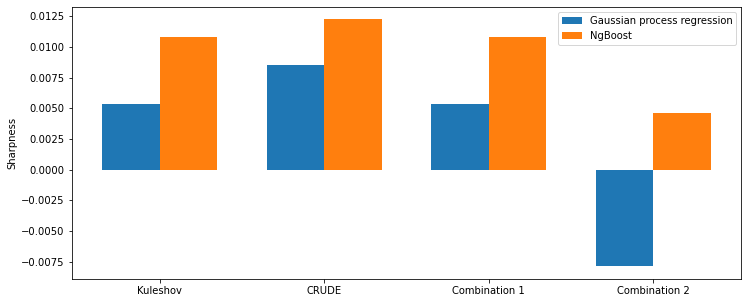

In [376]:
index = np.arange(4)
bar_width = 0.35

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.bar(index, sharp_gpr, bar_width, label='Gaussian process regression')
plt.bar(index + bar_width, sharp_ngb, bar_width, label='NgBoost')
plt.xticks(index + bar_width/2, ('Kuleshov', 'CRUDE', 'Combination 1', 'Combination 2'))
plt.ylabel('Sharpness')

plt.legend()
plt.show()

### When not to trust your model

In [118]:
# conf_int = [ngb_CI_kule, gpr_CI_kule, ngb_CI_crude, gpr_CI_crude, 
#           ngb_CI_comb, gpr_CI_comb, ngb_CI_comb2, gpr_CI_comb2]

flagged = np.zeros((len(cdf_cals_ngb), len(conf_int)))
index = 0

for conf in conf_int:
    for i in range(len(conf)):
        if conf[i] > 0.9:
            flagged[i, index] = 1
    index = index + 1
            

In [119]:
num_ones = sum(cell for row in flagged for cell in row)
print(num_ones)

1842.0


In [120]:
print(flagged.size)
print(num_ones/flagged.size)

17992
0.10237883503779457


### Combination coverage

In [79]:
def comb_coverage(comb, y_true_test):
   
    cov = []
    p_values = np.arange(0.05,1,0.05)
    
    for p in p_values:
        count = 0
        for i in range(len(comb)):
            comb_range = comb[i,1] - comb[i,0] 
            if comb_range < p:
                count = count + 1
        cov.append(count/len(comb))
        
    return cov

In [90]:
def comb_cov(comb, y_true_test):
   
    count = 0
    for i in range(len(comb)):
        comb_range = comb[i,1] - comb[i,0] 
        if comb_range < 0.95:
            count = count + 1
    cov = count/len(comb)
        
    return cov

In [80]:
comb_cov_ngb = comb_coverage(ngb_comb_intervals, y_true_test)
comb_cov_gpr = comb_coverage(gpr_comb_intervals, y_true_test)

comb_cov_ngb2 = comb_coverage(ngb_comb_intervals2, y_true_test)
comb_cov_gpr2 = comb_coverage(gpr_comb_intervals2, y_true_test)

In [91]:
comb_c_ngb = comb_cov(ngb_comb_intervals, y_true_test)
comb_c_gpr = comb_cov(gpr_comb_intervals, y_true_test)

comb_c_ngb2 = comb_cov(ngb_comb_intervals2, y_true_test)
comb_c_gpr2 = comb_cov(gpr_comb_intervals2, y_true_test)

In [92]:
print(comb_c_ngb, comb_c_gpr, comb_c_ngb2, comb_c_gpr2)

0.8070253445975989 1.0 0.8519341929746554 1.0


In [87]:
print(ngb_comb_intervals[0])
print(gpr_comb_intervals[0])
print(ngb_comb_intervals2[0])
print(gpr_comb_intervals2[0])

print(ngb_crude_range[0])
print(gpr_crude_range[0])
print(ngb_kuleshov_range[0])
print(gpr_kuleshov_range[0])

[-0.06559771  0.06524566]
[-0.35326363  0.32549825]
[-0.06559771  0.05195917]
[-0.35326363  0.22876734]
[-0.08199121  0.05195917]
[-0.48989314  0.22876734]
[-0.06559771  0.06524566]
[-0.35326363  0.32549825]


In [82]:
cov_kuleshov_gpr = np.zeros((len(cov_crude_gpr),1))
cov_kuleshov_ngb = np.zeros((len(cov_crude_gpr),1))
cov_unc_gpr = np.zeros((len(cov_crude_gpr),1))
cov_unc_ngb = np.zeros((len(cov_crude_gpr),1))

index = 0

for i in range(len(cov_kuleshov_calc_gpr)):
    if i%2==0:
        cov_kuleshov_gpr[index] = cov_kuleshov_calc_gpr[i]
        cov_kuleshov_ngb[index] = cov_kuleshov_calc_ngb[i]
        cov_unc_gpr[index] = cov_uncal_gpr[i]
        cov_unc_ngb[index] = cov_uncal_ngb[i]
        index = index + 1


In [105]:
print(cov_kuleshov_calc_gpr)

[0.9461983103601601, 0.8981769675411294, 0.8501556247220987, 0.7901289461983103, 0.7474433081369497, 0.7020898176967542, 0.6571809693196976, 0.6082703423743886, 0.5695864828812806, 0.5100044464206314, 0.45131169408626054, 0.40684748777234325, 0.3534904401956425, 0.308581591818586, 0.25477990217874613, 0.2023121387283237, 0.15251222765673633, 0.10271231658514896, 0.05380168963983993]


### Comparison of coverage/recalibration

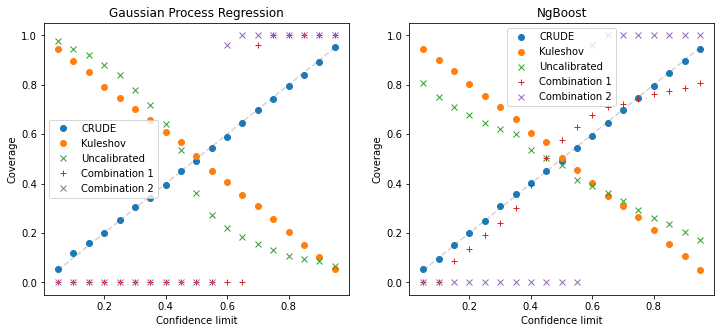

In [83]:
x = np.linspace(0.05, 0.95, 19)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(x, x + 0, linestyle="dashed", color='lightgray')
ax1.plot(x, cov_crude_gpr, 'o', label='CRUDE')
ax1.plot(x, cov_kuleshov_calc_gpr, 'o', label='Kuleshov')
ax1.plot(x, cov_uncal_gpr, 'x', label='Uncalibrated')
ax1.plot(x, comb_cov_gpr, '+', label='Combination 1')
ax1.plot(x, comb_cov_gpr2, 'x', label='Combination 2')
ax1.set_xlabel('Confidence limit')
ax1.set_ylabel('Coverage')
ax1.set_title('Gaussian Process Regression')
ax1.legend()

ax2.plot(x, x + 0, linestyle="dashed", color='lightgray')
ax2.plot(x, cov_crude_ngb, 'o', label='CRUDE')
ax2.plot(x, cov_kuleshov_calc_ngb, 'o', label='Kuleshov')
ax2.plot(x, cov_uncal_ngb, 'x', label='Uncalibrated')
ax2.plot(x, comb_cov_ngb, '+', label='Combination 1')
ax2.plot(x, comb_cov_gpr2, 'x', label='Combination 2')
ax2.set_xlabel('Confidence limit')
ax2.set_ylabel('Coverage')
ax2.set_title('NgBoost')
ax2.legend()

plt.show()

### Boxplot of sharpness

In [93]:
lst1 = ['NgBoost'] * len(ngb_comb_intervals)
lst2 = ['Gaussian Process Regression'] * len(ngb_comb_intervals)

In [94]:
interval_name = ['crude_interval', 'kuleshov_interval', 'comb1_interval', 'comb2_interval', 'ngb_or_gpr']
sharpness_ngb = pd.DataFrame(columns=interval_name)  
sharpness_gpr = pd.DataFrame(columns=interval_name) 
sharpness_ngb['ngb_or_gpr'] = lst1
sharpness_gpr['ngb_or_gpr'] = lst2

In [95]:
for i in range(len(ngb_comb_intervals)):
    sharpness_ngb.loc[i, 'crude_interval'] = ngb_crude_range[i,1] - ngb_crude_range[i,0]
    sharpness_ngb.loc[i, 'kuleshov_interval'] = ngb_kuleshov_range[i,1] - ngb_kuleshov_range[i,0]
    sharpness_ngb.loc[i, 'comb1_interval'] = ngb_comb_intervals[i,1] - ngb_comb_intervals[i,0]
    sharpness_ngb.loc[i, 'comb2_interval'] = ngb_comb_intervals2[i,1] - ngb_comb_intervals2[i,0]


In [96]:
for i in range(len(ngb_comb_intervals)):
    sharpness_gpr.loc[i, 'crude_interval'] = gpr_crude_range[i,1] - gpr_crude_range[i,0]
    sharpness_gpr.loc[i, 'kuleshov_interval'] = gpr_kuleshov_range[i,1] - gpr_kuleshov_range[i,0]
    sharpness_gpr.loc[i, 'comb1_interval'] = gpr_comb_intervals[i,1] - gpr_comb_intervals[i,0]
    sharpness_gpr.loc[i, 'comb2_interval'] = gpr_comb_intervals2[i,1] - gpr_comb_intervals2[i,0]


In [101]:
print(ngb_crude_range[0], gpr_crude_range[0])

[-0.08199121  0.05195917] [-0.48989314  0.22876734]


In [97]:
frames_ = [sharpness_ngb, sharpness_gpr]
sharpness_boxplot = pd.concat(frames_)

In [98]:
new_df = pd.melt(sharpness_boxplot.iloc[:,:4])
print(new_df)

             variable     value
0      crude_interval   0.13395
1      crude_interval  0.108283
2      crude_interval  0.165453
3      crude_interval  0.404071
4      crude_interval  0.402611
...               ...       ...
17987  comb2_interval  0.583984
17988  comb2_interval  0.583016
17989  comb2_interval  0.591674
17990  comb2_interval  0.582749
17991  comb2_interval  0.584701

[17992 rows x 2 columns]


In [99]:
for i in range(len(new_df)):
    if i < len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    elif i >= len(ngb_crude_range) and i < 2*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'
    elif i >= 2*len(ngb_crude_range) and i < 3*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    elif i >= 3*len(ngb_crude_range) and i < 4*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'
    elif i >= 4*len(ngb_crude_range) and i < 5*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    elif i >= 5*len(ngb_crude_range) and i < 6*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'
    elif i >= 6*len(ngb_crude_range) and i < 7*len(ngb_crude_range):
        new_df.loc[i, 'ngb_or_gpr'] = 'NgBoost'
    else:
        new_df.loc[i, 'ngb_or_gpr'] = 'Gaussian Process Regression'

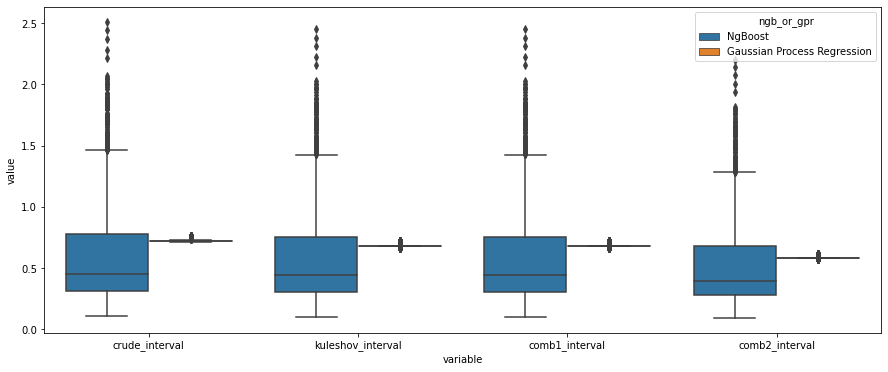

In [100]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
ax = sns.boxplot(x='variable', y="value", hue='ngb_or_gpr', data=new_df)

### Coverage RMSE

In [102]:
lst = ['cov_uncal_gpr', 'cov_crude_gpr', 'cov_kuleshov_gpr', 'comb_cov_gpr', 'comb_cov_gpr2',
       'cov_uncal_ngb', 'cov_crude_ngb', 'cov_kuleshov_ngb', 'comb_cov_ngb', 'comb_cov_ngb2']
coverages = [cov_uncal_gpr, cov_crude_gpr, cov_kuleshov_calc_gpr, comb_cov_gpr, comb_cov_gpr2,
            cov_uncal_ngb, cov_crude_ngb, cov_kuleshov_calc_ngb, comb_cov_ngb, comb_cov_ngb2]

df = pd.DataFrame(columns=lst)  

In [103]:
for (cov, col) in zip(coverages, lst):
    for i in range(len(cov_unc_gpr)):
        df.loc[i, col] = abs(x[i]-cov[i])

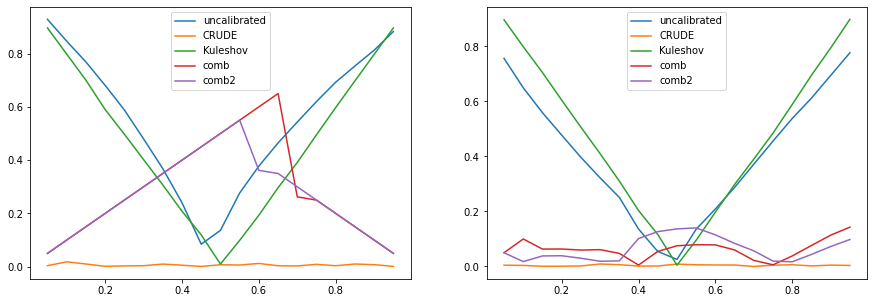

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x, df.cov_uncal_gpr.values, label='uncalibrated')
ax1.plot(x, df.cov_crude_gpr.values, label='CRUDE')
ax1.plot(x, df.cov_kuleshov_gpr.values, label='Kuleshov')
ax1.plot(x, df.comb_cov_gpr.values, label='comb')
ax1.plot(x, df.comb_cov_gpr2.values, label='comb2')
ax1.legend()

ax2.plot(x, df.cov_uncal_ngb.values, label='uncalibrated')
ax2.plot(x, df.cov_crude_ngb.values, label='CRUDE')
ax2.plot(x, df.cov_kuleshov_ngb.values, label='Kuleshov')
ax2.plot(x, df.comb_cov_ngb.values, label='comb')
ax2.plot(x, df.comb_cov_ngb2.values, label='comb2')
ax2.legend()

plt.show()

In [ ]:
rmse = []

for col in lst:
    sum_ = sum(df[col].values)
    rmse.append(sum_/len(df[col]))


In [ ]:
for (i, col) in zip(rmse, lst):
    print(col, i)

In [ ]:
index = np.arange(5)
bar_width = 0.35
gpr = rmse[0:5]
ngb = rmse[5:10]

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.bar(index, gpr, bar_width, label='Gaussian process regression')
plt.bar(index + bar_width, ngb, bar_width, label='NgBoost')
plt.xticks(index + bar_width/2, ('Uncalibrated', 'CRUDE', 'Kuleshov', 'Combination 1', 'Combination 2'))
plt.ylabel('RMSE')

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.bar(index[0:3], gpr[0:3], bar_width, label='Gaussian process regression')
plt.bar(index[0:3] + bar_width, ngb[0:3], bar_width, label='NgBoost')
plt.xticks(index[0:3] + bar_width/2, ('Uncalibrated', 'CRUDE', 'Kuleshov'))
plt.ylabel('RMSE')

plt.legend()
plt.show()